# Kyle Calabro
# DATA 750 - Thesis in Data Science
# 12 August 2021
---

# Notebook Two:
---
## Baseline Models and Analyzing Performance

In [1]:
import librosa
import librosa.display

%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import specgram

import seaborn as sns

import IPython.display as ipd
from IPython.display import Audio

import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import sys
import warnings

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# To ignore deprecation warnings...
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

np.random.seed(42)
tf.random.set_random_seed(42)

# Utility Functions
---

In [2]:
# To plot the accuracy of a CNN across epochs

def plot_accuracy(model_hist, model_title):
    plt.plot(model_hist.history["acc"])
    plt.plot(model_hist.history["val_acc"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc = "best")
    plt.show();

In [3]:
# To plot the loss of a CNN across epochs

def plot_loss(model_hist, model_title):
    plt.plot(model_hist.history["loss"])
    plt.plot(model_hist.history["val_loss"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = "best")
    plt.show();

In [4]:
# To get the predicted labels of a given CNN model
# Params:
    # X_test: features from the test set data
    # model: the CNN model to make predictions with
    # encoder: The label encoder object used to encode labels initially

def get_predictions(X_test, model, encoder):
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis = 1)
    y_pred = y_pred.astype(int).flatten()
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred

In [5]:
# To get the actual labels of a given CNN model
# Params:
    # y_test: target variable from the test set
    # encoder: The label encoder object used to encode labels initially

def get_labels(y_test, encoder):
    labels = y_test.argmax(axis = 1)
    labels = labels.astype(int).flatten()
    labels = encoder.inverse_transform(labels)
    return labels

In [6]:
# To print a classification report based on predictions from a CNN 
# and provided actual labels
# Params:
    # labels: The actual labels of the target variable
    # y_pred: The predicted labels of the target variable
    # encoder: The label encoder object used to encode labels initially
    
def get_report(labels, y_pred, encoder):
    target_names = encoder.classes_
    print(classification_report(labels, y_pred, target_names))

# Bringing in the Data
----

In [7]:
df = pd.read_csv("modeling_df.csv", index_col = 0)

In [8]:
df.head()

,Gender,Emotion,Actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,male,Surprise,1,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,...,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218,-71.200218
1,male,Surprise,1,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,-70.461052,...,-70.461052,-70.461052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,Angry,1,-64.176788,-64.393738,-64.444954,-64.268044,-64.303825,-64.468147,-64.468147,...,-64.468147,-64.468147,-64.468147,-64.468147,-64.422607,-64.364937,-64.468147,-64.465858,-64.354759,-64.385941
3,male,Fear,1,-73.280296,-73.280296,-73.280296,-73.280296,-73.280296,-73.255249,-73.086319,...,-72.866135,-73.029083,-73.021973,-73.157417,-73.278503,-73.280296,-73.272202,-73.042091,-72.969475,-73.264915
4,male,Fear,1,-44.965843,-44.467876,-44.512608,-44.934807,-44.679760,-44.350895,-45.161110,...,-42.328346,-42.546494,-43.290047,-42.981064,-43.380680,-44.499775,-44.815922,-45.377876,-45.876091,-46.404274


## Splitting the data into training and test sets, 80% train, 20% test
---

In [9]:
train_data, test_data = train_test_split(df, test_size = .2, random_state = 42, stratify = df[["Emotion", "Gender", "Actor"]])

X_train = train_data.iloc[:, 3:]
y_train = train_data.iloc[:, :2].drop(columns = ["Gender"])

X_test = test_data.iloc[:, 3:]
y_test = test_data.iloc[:, :2].drop(columns = ["Gender"])

In [10]:
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

Training Set Size: (1152, 259)
Test Set Size: (288, 259)


## Standardizing the data and one-hot encoding the target variable to prepare for CNN deployment
---

In [11]:
# Standardize the data
X_mean = np.mean(X_train, axis = 0)
X_std = np.std(X_train, axis = 0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [12]:
# Converting data to arrays for use in Tensorflow/Keras
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [13]:
# One-hot encoding
encoder = LabelEncoder()

y_train = to_categorical(encoder.fit_transform(y_train))
y_test = to_categorical(encoder.fit_transform(y_test))

In [14]:
print(encoder.classes_)

['Angry' 'Calm' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


## Reshaping the data to include 3D tensor
---

In [15]:
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

In [16]:
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

Training Set Size: (1152, 259, 1)
Test Set Size: (288, 259, 1)


## Initial Modeling
---

In [17]:
optimizer = keras.optimizers.Adam(lr = 0.001)

In [18]:
init_model = tf.keras.Sequential()

init_model.add(layers.Conv1D(64, kernel_size = 10, activation = "relu", input_shape = (X_train.shape[1], 1)))
init_model.add(layers.Conv1D(128, kernel_size = 10 ,activation = "relu", kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
init_model.add(layers.MaxPooling1D(pool_size = 8))
init_model.add(layers.Dropout(0.4))
init_model.add(layers.Conv1D(128, kernel_size = 10,activation = "relu"))
init_model.add(layers.MaxPooling1D(pool_size = 8))
init_model.add(layers.Dropout(0.4))
init_model.add(layers.Flatten())
init_model.add(layers.Dense(256, activation = "relu"))
init_model.add(layers.Dropout(0.4))
init_model.add(layers.Dense(8, activation = "sigmoid"))

init_model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
init_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 250, 64)           704       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
____

In [19]:
start_time_init_model = time.time()

init_model_hist = init_model.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data = (X_test, y_test))

end_time_init_model = time.time()

Train on 1152 samples, validate on 288 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
1152/1152 [==============================] - 1s 1ms/sample - loss: 2.4239 - acc: 0.2240 - val_loss: 2.0888 - val_acc: 0.2743
Epoch 2/30
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.9393 - acc: 0.2821 - val_loss: 1.8897 - val_acc: 0.2778
Epoch 3/30
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.8501 - acc: 0.2734 - val_loss: 1.8359 - val_acc: 0.2882
Epoch 4/30
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.7877 - acc: 0.2943 - val_loss: 1.7691 - val_acc: 0.3125
Epoch 5/30
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.7575 - acc: 0.3073 - val_loss: 1.7618 - val_acc: 0.3542
Epoch 6/30
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.7250 - acc: 0.3090 - val_loss: 1.7125 - val_acc: 0.3576
Epoch 7/30
1152/1152 [=====================

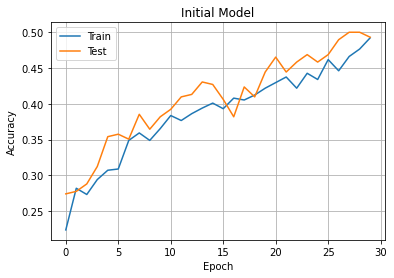

In [20]:
plot_accuracy(init_model_hist, "Initial Model")

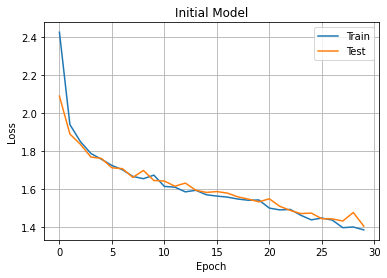

In [21]:
plot_loss(init_model_hist, "Initial Model")

In [22]:
print("Elapsed Training Time: {} seconds".format(end_time_init_model - start_time_init_model), "\n")

Elapsed Training Time: 37.504825830459595 seconds 



In [23]:
init_model.evaluate(X_test, y_test)

288/288 [==============================] - 0s 238us/sample - loss: 1.4064 - acc: 0.4931


[1.4063684807883368, 0.49305555]

In [24]:
y_pred_init_model = get_predictions(X_test, init_model, encoder)

In [25]:
y_labels = get_labels(y_test, encoder)

In [26]:
get_report(y_labels, y_pred_init_model, encoder)

              precision    recall  f1-score   support

       Angry       0.59      0.54      0.57        35
        Calm       0.48      0.78      0.60        36
     Disgust       0.54      0.72      0.62        39
        Fear       0.75      0.23      0.35        40
       Happy       0.30      0.36      0.33        36
     Neutral       0.42      0.33      0.37        24
         Sad       0.50      0.34      0.41        38
    Surprise       0.52      0.60      0.56        40

    accuracy                           0.49       288
   macro avg       0.51      0.49      0.47       288
weighted avg       0.52      0.49      0.48       288



## Hyperparameter Tuning
---
### Use GridSearch Cross-Validation to find best hyperparameters for the CNN and re-evaluate performance

In [27]:
def generate_clf(optimizer = optimizer):
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size = 10, activation = "relu", input_shape = (X_train.shape[1], 1)))
    model.add(layers.Conv1D(128, kernel_size = 10, activation = "relu", kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size = 8))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size = 10, activation = "relu"))
    model.add(layers.MaxPooling1D(pool_size = 8))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation = "sigmoid"))
    model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [28]:
clf = KerasClassifier(build_fn = generate_clf)

params = {
    "batch_size": [30, 32, 34],
    "nb_epoch": [25, 50, 75],
    "optimizer": ["adam","SGD"]
    }

grid_search = GridSearchCV(estimator = clf, param_grid = params, scoring = "accuracy", cv = 5)

grid_search = grid_search.fit(X_train, np.argmax(y_train, axis = 1))

1152/1152 [==============================] - 2s 2ms/sample - loss: 2.3865 - acc: 0.2135


In [29]:
grid_search.best_params_

{'batch_size': 32, 'nb_epoch': 50, 'optimizer': 'adam'}

In [30]:
grid_search.best_score_

0.27608507434594387

## Deploy New CNN with Tuned Hyperparameters
---

In [31]:
gs_model = tf.keras.Sequential()

gs_model.add(layers.Conv1D(64, kernel_size = 10, activation = "relu", input_shape = (X_train.shape[1], 1)))
gs_model.add(layers.Conv1D(128, kernel_size = 10 ,activation = "relu", kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
gs_model.add(layers.MaxPooling1D(pool_size = 8))
gs_model.add(layers.Dropout(0.4))
gs_model.add(layers.Conv1D(128, kernel_size = 10,activation = "relu"))
gs_model.add(layers.MaxPooling1D(pool_size = 8))
gs_model.add(layers.Dropout(0.4))
gs_model.add(layers.Flatten())
gs_model.add(layers.Dense(256, activation = "relu"))
gs_model.add(layers.Dropout(0.4))
gs_model.add(layers.Dense(8, activation = "sigmoid"))

gs_model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
gs_model.summary()

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_276 (Conv1D)          (None, 250, 64)           704       
_________________________________________________________________
conv1d_277 (Conv1D)          (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_184 (MaxPoolin (None, 30, 128)           0         
_________________________________________________________________
dropout_276 (Dropout)        (None, 30, 128)           0         
_________________________________________________________________
conv1d_278 (Conv1D)          (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_185 (MaxPoolin (None, 2, 128)            0         
_________________________________________________________________
dropout_277 (Dropout)        (None, 2, 128)          

In [32]:
start_time_gs_model = time.time()

gs_model_hist = gs_model.fit(X_train, y_train, batch_size = 32, epochs = 50, validation_data = (X_test, y_test))

end_time_gs_model = time.time()

Train on 1152 samples, validate on 288 samples
Epoch 1/50
1152/1152 [==============================] - 4s 4ms/sample - loss: 2.1573 - acc: 0.2014 - val_loss: 1.9248 - val_acc: 0.2535
Epoch 2/50
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.8418 - acc: 0.2188 - val_loss: 1.8611 - val_acc: 0.1944
Epoch 3/50
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.8145 - acc: 0.2309 - val_loss: 1.8464 - val_acc: 0.2431
Epoch 4/50
1152/1152 [==============================] - 2s 1ms/sample - loss: 1.7987 - acc: 0.2865 - val_loss: 1.8335 - val_acc: 0.2465
Epoch 5/50
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.7420 - acc: 0.3116 - val_loss: 1.7475 - val_acc: 0.3160
Epoch 6/50
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.7092 - acc: 0.3438 - val_loss: 1.6909 - val_acc: 0.3854
Epoch 7/50
1152/1152 [==============================] - 1s 1ms/sample - loss: 1.6747 - acc: 0.3516 - val_loss: 1.6729 - val_acc: 0.3611
E

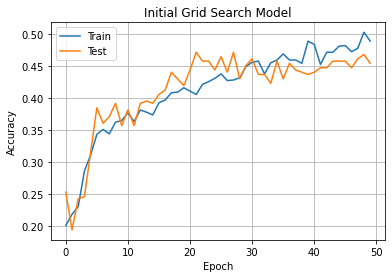

In [33]:
plot_accuracy(gs_model_hist, "Initial Grid Search Model")

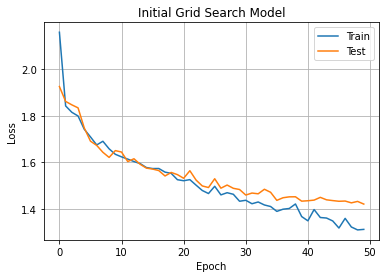

In [34]:
plot_loss(gs_model_hist, "Initial Grid Search Model")

In [35]:
print("Elapsed Training Time: {} seconds".format(end_time_gs_model - start_time_gs_model), "\n")

Elapsed Training Time: 77.80577325820923 seconds 



In [36]:
gs_model.evaluate(X_test, y_test)

288/288 [==============================] - 0s 282us/sample - loss: 1.4216 - acc: 0.4549


[1.4215640359454684, 0.4548611]

In [37]:
y_pred_gs_model = get_predictions(X_test, gs_model, encoder)

In [38]:
get_report(y_labels, y_pred_gs_model, encoder)

              precision    recall  f1-score   support

       Angry       0.54      0.60      0.57        35
        Calm       0.56      0.75      0.64        36
     Disgust       0.54      0.74      0.62        39
        Fear       0.70      0.17      0.28        40
       Happy       0.18      0.19      0.19        36
     Neutral       0.31      0.42      0.36        24
         Sad       0.56      0.39      0.46        38
    Surprise       0.38      0.38      0.38        40

    accuracy                           0.45       288
   macro avg       0.47      0.46      0.44       288
weighted avg       0.48      0.45      0.44       288

